In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
from math import log2, floor, ceil
from statistics import mean, median

In [2]:
def load_file(filename):
    a = np.loadtxt(filename, dtype='str', comments='#')
    rsp = [round(float(x),6) for x in  a[:,0]]
    latencies = a[:,1]
    times = a[:,2]
    processors = a[:,3]
    work = a[:,4]
    i_steals = a[:,16]
    e_steals = a[:,17]
    return rsp, latencies, times, processors, work, i_steals, e_steals

directory = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba/proba_steal_50p/"
directory_70p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba/proba_steal_70p/"
directory_80p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba/proba_steal_80p/"
directory_90p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba/proba_steal_90p/"

In [3]:
def compute_average(values, latence):
    average = defaultdict(int)
    run_number = defaultdict(int)
    
    for i in range(len(rsp)):
        if int(latencies[i]) == latence:
            run_number[float(rsp[i])] += 1
            average[float(rsp[i])] += int(values[i])
            
    for cle in average:
        average[cle] /= run_number[cle]
    return average

def compute_overhead_for_latence(data, latence):
    rsp, latencies, times, processors, work, i_s, e_s = data
    all_average = defaultdict(list)
    average = defaultdict(int)
    run_number = defaultdict(int)
    
    for i in range(len(rsp)):
        if int(latencies[i]) == latence:
            #run_number[float(rsp[i])] += 1
            all_average[float(rsp[i])].append(float(int(times[i]) - int(work[i])/int(processors[i])))
    for cle in sorted(all_average):
        size = len(all_average[cle])
        #average[cle] = mean(all_average[cle][ceil(0.25*size):ceil(0.75*size)])
        average[cle] = mean(all_average[cle])
        #print(mean(all_average[cle]), mean(all_average[cle][ceil(0.25*size):ceil(0.75*size)]))
  #      average[cle] = median(all_average[cle])

    return all_average, average, min(average.keys(), key=lambda x : average[x])


def compute_overhead(data, latence, variable):
    rsp, latencies, times, processors, work, i_s, e_s = data
    average = defaultdict(int)
    run_number = defaultdict(int)
    average = 0
    run_number = 0
    
    for i in range(len(rsp)):
        if float(rsp[i]) == variable and float(latencies[i]) == latence:
            run_number += 1
            average += float(int(times[i]) - int(work[i])/int(processors[i]))
            
    return average/run_number

In [4]:
def plot_for_best(filename):
    best = dict()
    base_line = dict()
    data = load_file(filename)
    latencies = data[1]
    for latence in sorted(set(latencies), key=lambda x: int(x)):
        all_average, avg_overhead, minimum  = compute_overhead_for_latence(data, int(latence))
        best_avg_overhead = compute_overhead(data, int(latence), minimum)
        best[latence] = best_avg_overhead
        if minimum < 1:
            base_line[latence] = compute_overhead(data, int(latence), 0.5)
            #print(latence, minimum)
    
    return best, base_line

In [5]:
def latence_for_best_param(filename):
    data = load_file(filename)
    latencies = data[1]
    best = dict()

    for latence in sorted(set(latencies), key=lambda x: int(x)):
        all_average, overhead, minimum = compute_overhead_for_latence(data, int(latence))
        #plt.subplot(223)
        plt.plot(overhead.keys(), overhead.values())
        best[latence] = minimum
    return best

In [6]:
def best_overhead_dict(directory):
    best_value_p = defaultdict(dict)
    best_value_w = defaultdict(dict)
    best_value_l = defaultdict(dict)

    for w in (10000000,50000000,100000000,500000000):
        for p in (16,32):
            filename = directory + "vss_proba_" + str(p) + "_" + str(w)
            best, _ = plot_for_best(filename)
            for latence in best.keys():
                best_value_w[(p, int(latence))][w]=best[latence]
                best_value_p[(w, int(latence))][p]=best[latence]
                best_value_l[(w, p)][int(latence)]=best[latence]

    return best_value_w, best_value_p, best_value_l

In [7]:
def best_value_dict(directory, seuil):
    best_value_p = defaultdict(dict)
    best_value_w = defaultdict(dict)
    best_value_l = defaultdict(dict)

    for w in (10000000,50000000,100000000,500000000):
        for p in (16,32,64):
            filename = directory + "vss_proba_" + str(p) + "_" + str(w)
            data = load_file(filename)
            for latence in (128,256,512,1024):
                _, overhead, minimum = compute_overhead_for_latence(data, latence)
                
                overhead_min = overhead[minimum]
                interval_max = overhead[minimum]  + overhead[minimum]*seuil/100

                #print(minimum, overhead[minimum], interval_max)
                
                
                overhead_plage = list(filter(lambda x : overhead_min <= overhead[x] <= interval_max, overhead))
                
                #print([(x, overhead[x]) for x in overhead_plage])
                
                best_value_w[(p, int(latence))][w]= overhead_plage
                best_value_p[(w, int(latence))][p]= overhead_plage
                best_value_l[(w, p)][int(latence)]= overhead_plage

    return best_value_w, best_value_p, best_value_l



## overhead en fonction proba $\lambda={128,256,512}$, $p=16,32,64$, $W=10^7,5.10^7,10^8,5.10^8$

/home/khatiri/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


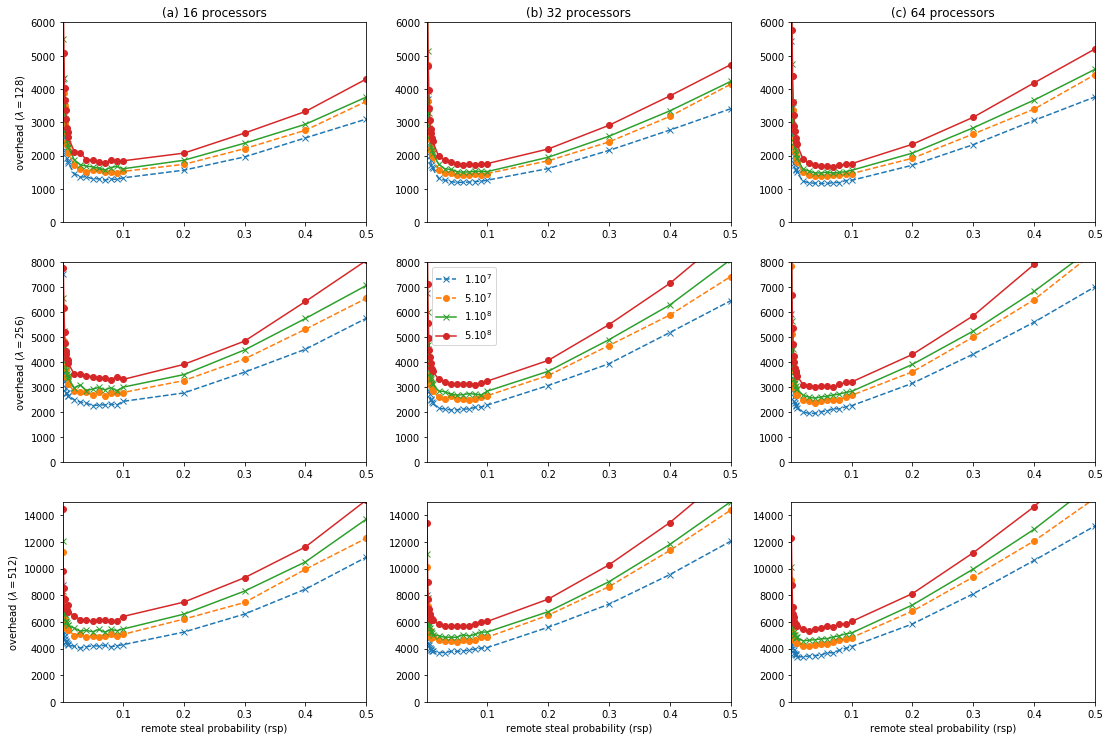

In [8]:
fig = plt.figure()
fig.set_size_inches(18.5, 12.5, forward=True)

plt.subplot(331)
#plt.xlim(0.001, 0.5)
position = 330
for (l,lim) in sorted({(128,6000),(256,8000),(512,15000)}):
    for p,c in sorted({(16,"(a)"),(32,"(b)"),(64,"(c)")}):
        #position
        position += 1
        plt.subplot(position)
        
        #labels
        if l == 512:
            plt.xlabel("remote steal probability (rsp)")
        if l == 128:
            plt.title(c+" "+str(p)+" processors")
        if p == 16:
            plt.ylabel("overhead ($\lambda = "+str(l)+"$)")
        
        #limits
        plt.xlim(0.001, 0.5)
        plt.ylim(0, lim)
        
        #plots
        for w1, w2, s in sorted({(10000000,"1.$10^7$", "x--"),(50000000,"5.$10^7$", "o--"), (100000000,"1.$10^8$", "x-"), (500000000,"5.$10^8$", "o-")}):
            data = load_file(directory + "vss_proba_"+str(p)+"_"+str(w1))
            #plt.title("l="+str(l)+" p="+str(p)+" w="+str(w1))
            all_average, overhead, minimum = compute_overhead_for_latence(data, l)
            plt.plot(overhead.keys(), overhead.values(), s, label=w2)
        
        #legend
        if p == 32 and l == 256: 
            plt.legend()
        plt.savefig('/tmp/overhead_according_rsp_l_2.pdf',bbox_inches='tight')

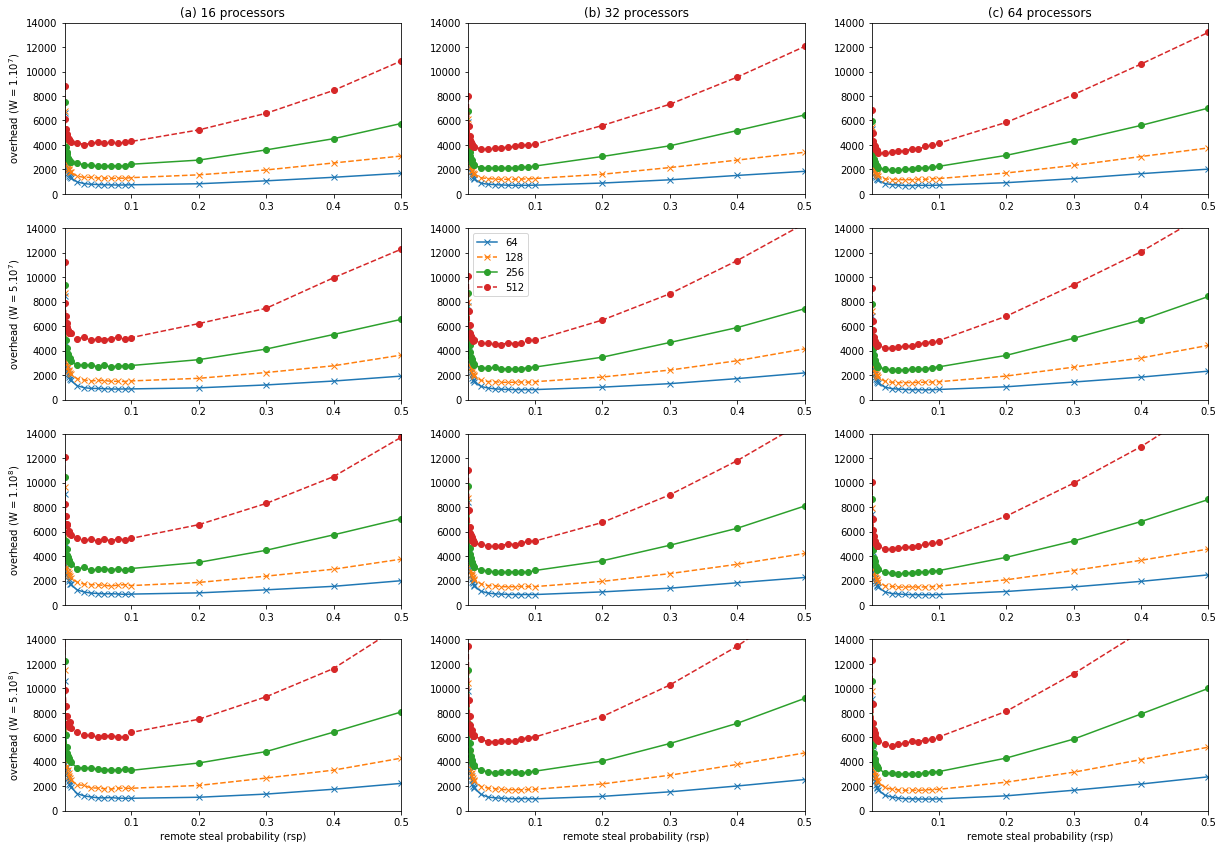

In [9]:
fig = plt.figure()
fig.set_size_inches(20.5, 14.5, forward=True)

position = 0
for w1, w2 in sorted({(10000000,"1.$10^7$"),(50000000,"5.$10^7$"), (100000000,"1.$10^8$"), (500000000,"5.$10^8$")}):
    for p,c in sorted({(16,"(a)"),(32,"(b)"),(64,"(c)")}):
        #position
        position += 1
        plt.subplot(4, 3, position)
        plt.ylim(0,14000)

        #plots
        data = load_file(directory + "vss_proba_"+str(p)+"_"+str(w1))
        
        for l,s in sorted({(64, "x-"), (128, "x--"), (256, "o-"), (512, "o--")}):
            if w1 == 10000000:
                plt.title(c+" "+str(p)+" processors")
            if w1 == 500000000:
                plt.xlabel("remote steal probability (rsp)")
            if p == 16:
                plt.ylabel("overhead (W = "+w2+")")
            
            plt.xlim(0.001, 0.5)
            all_average, overhead, minimum = compute_overhead_for_latence(data, l)
            plt.plot(overhead.keys(), overhead.values(), s, label=l)
        
        #legend
        if p == 32 and w1 == 50000000: 
            plt.legend()
        plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/overhead_according_rsp_w.pdf',bbox_inches='tight')


#en fonction $W$


In [10]:
def boxdata(p, w, l, rspmin, rspmax):
    data = load_file(directory + "vss_proba_{}_{}".format(p,w))
    all_average, overhead, minimum = compute_overhead_for_latence(data, l)
    #print(all_average)
    return [all_average[x] for x in all_average.keys() if rspmin <= x and x <= rspmax], \
[round(x,6) for x in all_average.keys() if rspmin <= x and x <= rspmax]
    


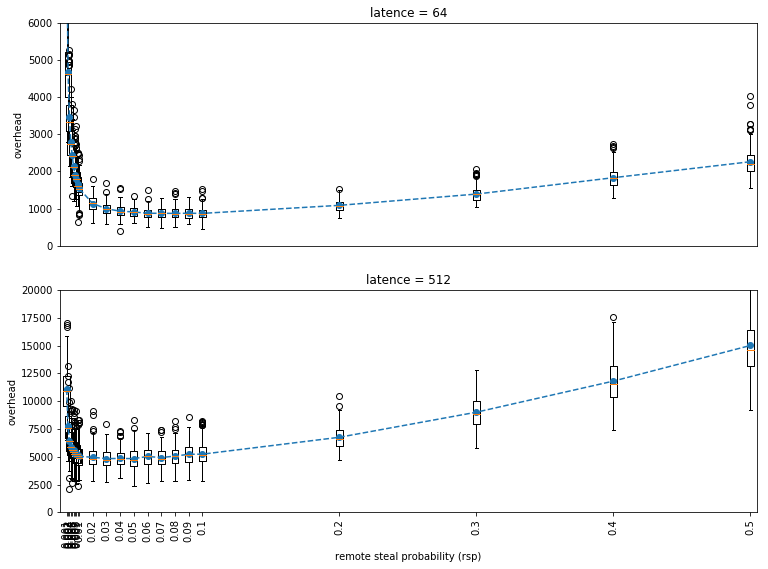

In [12]:
fig = plt.figure()
fig.set_size_inches(12.5, 9, forward=True)

plt.subplot(2, 1, 1)
list_avrg, list_keys = boxdata(32, 100000000, 64, 0, 0.5)
plt.title("latence = 64")
#plt.xlabel("remote steal probability (rsp)")
plt.ylabel("overhead")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

data = load_file(directory + "vss_proba_32_100000000")

plt.ylim(0, 6000)
#plt.xticks(rotation=90)
w = [0.1]*len(list_keys)
keys_positions = [x*100 for x in list_keys]
plt.boxplot(list_avrg, positions=keys_positions, labels = list_keys) 
_, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot([x*100 for x in overhead.keys()], overhead.values(), "o--", label="latence = 64")

plt.subplot(2, 1, 2)
list_avrg, list_keys = boxdata(32, 100000000, 512, 0, 0.5)
plt.title("latence = 512")
plt.xlabel("remote steal probability (rsp)")
plt.ylabel("overhead")

data = load_file(directory + "vss_proba_32_100000000")

plt.ylim(0, 20000)
plt.xticks(rotation=90)
w = [0.1]*len(list_keys)
keys_positions = [x*100 for x in list_keys]
plt.boxplot(list_avrg, positions=keys_positions, labels = list_keys) 
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot([x*100 for x in overhead.keys()], overhead.values(), "o--", label="latence = 512")
plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/box_overhead_according_rsp_w100000000_32.pdf',bbox_inches='tight')


#en fonction $latence$


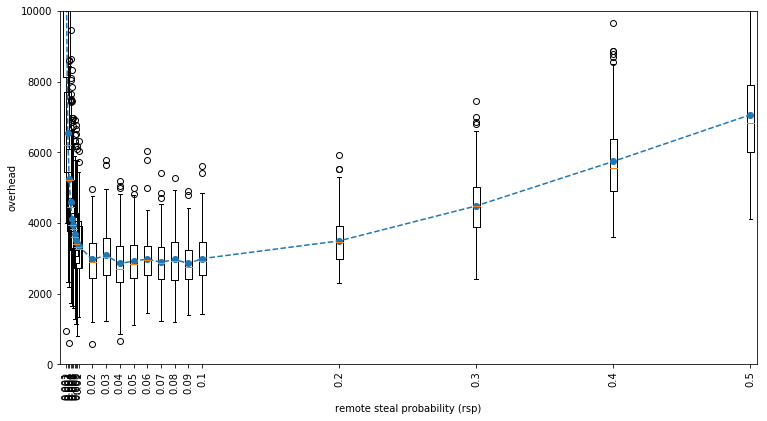

In [63]:
fig = plt.figure()
fig.set_size_inches(12.5, 6.5, forward=True)
list_avrg, list_keys = boxdata(16, 100000000, 256, 0, 0.5)
maxim = max(best_w[(16,256)][100000000])
#plt.subplot(111)

plt.xlabel("remote steal probability (rsp)")
plt.ylabel("overhead")

data = load_file(directory + "vss_proba_16_100000000")

plt.ylim(0, 10000)
plt.xticks(rotation=90)
w = [0.1]*len(list_keys)
keys_positions = [x*100 for x in list_keys]
plt.boxplot(list_avrg, positions=keys_positions, labels = list_keys) 
_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot([x*100 for x in overhead.keys()], overhead.values(), "o--", label="latence = 256")

plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/zoom_overhead_according_rsp_w100000000_16_256.pdf',bbox_inches='tight')


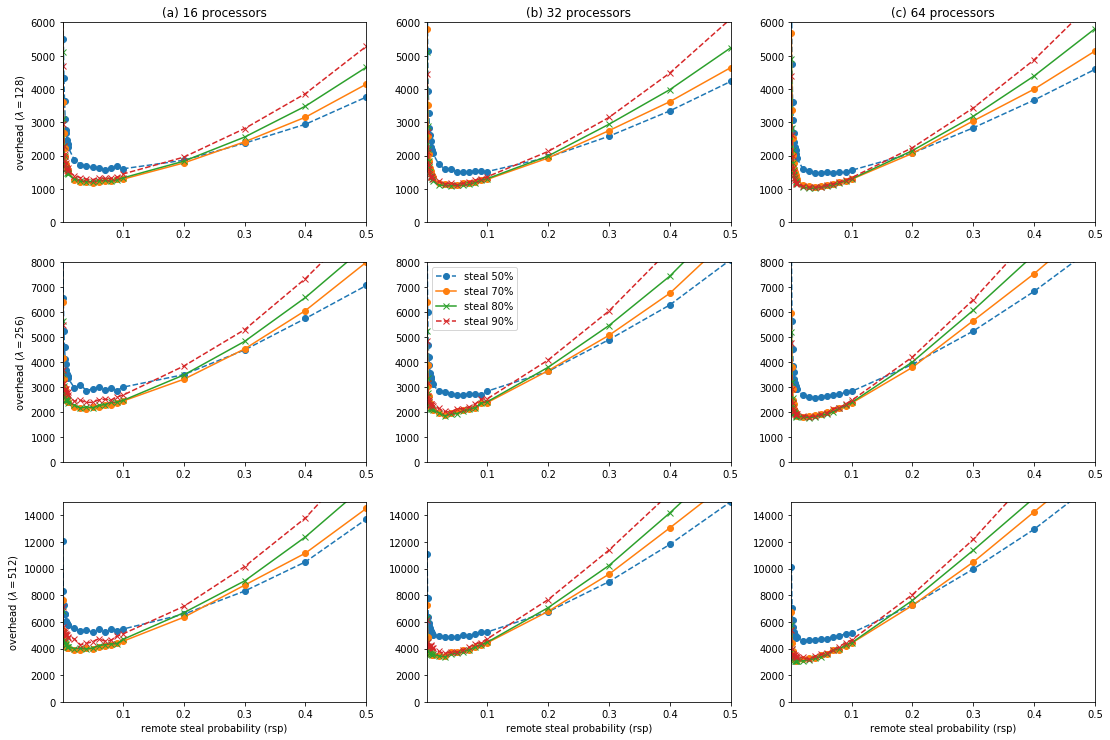

In [14]:
fig = plt.figure()
fig.set_size_inches(18.5, 12.5, forward=True)

plt.subplot(331)
#plt.xlim(0.001, 0.5)
position = 330
for (l,lim) in sorted({(128,6000),(256,8000),(512,15000)}):
    for p,c in sorted({(16,"(a)"),(32,"(b)"),(64,"(c)")}):
        #position
        position += 1
        plt.subplot(position)
        
        #labels
        if l == 512:
            plt.xlabel("remote steal probability (rsp)")
        if l == 128:
            plt.title(c+" "+str(p)+" processors")
        if p == 16:
            plt.ylabel("overhead ($\lambda = "+str(l)+"$)")
        
        #limits
        plt.xlim(0.001, 0.5)
        plt.ylim(0, lim)
        
        #plots
        for w1, w2, s in {(100000000,"1.$10^8$", "x--")}:
            filename = directory  + "vss_proba_"+str(p)+"_"+str(w1)
            data = load_file(filename)
            _, overhead, minimum = compute_overhead_for_latence(data, l)
            plt.plot(overhead.keys(), overhead.values(), "o--", label="steal 50%")

            filename = directory_70p + "vss_proba_"+str(p)+"_"+str(w1)
            data = load_file(filename)
            _, overhead, minimum = compute_overhead_for_latence(data, l)
            plt.plot(overhead.keys(), overhead.values(), "o-", label="steal 70%")
            filename = directory_80p + "vss_proba_"+str(p)+"_"+str(w1)
            data = load_file(filename)
            _, overhead, minimum = compute_overhead_for_latence(data, l)
            plt.plot(overhead.keys(), overhead.values(), "x-", label="steal 80%")

            filename = directory_90p + "vss_proba_"+str(p)+"_"+str(w1)
            data = load_file(filename)
            _, overhead, minimum = compute_overhead_for_latence(data, l)
            plt.plot(overhead.keys(), overhead.values(), "x--", label="steal 90%")
                    
                                        
        #legend
        if p == 32 and l == 256: 
            plt.legend()
plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/comp_steal_amount_overhead_according_rsp.pdf',bbox_inches='tight')


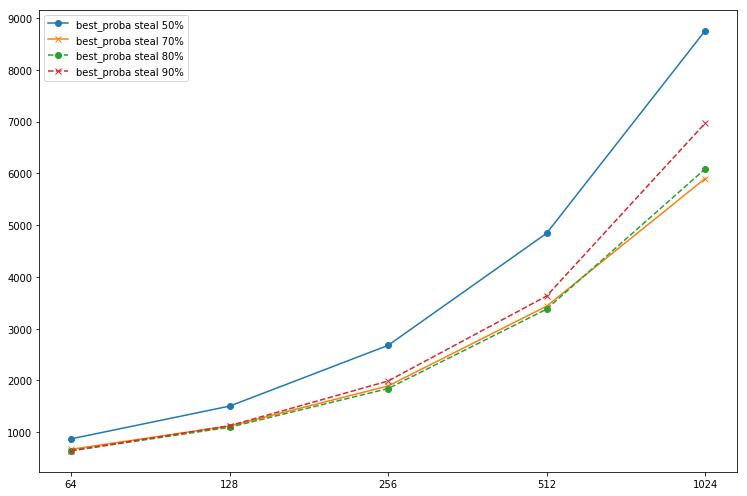

In [16]:
fig = plt.figure()
fig.set_size_inches(12.5, 8.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"

filename = directory  + "vss_proba_32_100000000"
best_proba_50, _ = plot_for_best(filename)


filename = directory_90p + "vss_proba_32_100000000"
best_proba_90, _ = plot_for_best(filename)

filename = directory_80p + "vss_proba_32_100000000"
best_proba_80, _ = plot_for_best(filename)

filename = directory_70p + "vss_proba_32_100000000"
best_proba_70, _ = plot_for_best(filename)

#filename = directory_r + "vss_proba_dynamic_40p_32_100000000"
#best_proba_dynamic_60, _ = plot_for_best(filename)

#plt.plot(base_line.keys(), base_line.values(), 'o-', label="best_proba")
plt.plot(best_proba_50.keys(), best_proba_50.values(), 'o-', label="best_proba steal 50%")
plt.plot(best_proba_70.keys(), best_proba_70.values(), 'x-', label="best_proba steal 70%")
plt.plot(best_proba_80.keys(), best_proba_80.values(), 'o--', label="best_proba steal 80%")
plt.plot(best_proba_90.keys(), best_proba_90.values(), 'x--', label="best_proba steal 90%")

plt.legend()


plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/comp_steal_amount_for_best_overhead_according_rsp_l.pdf',bbox_inches='tight')

#fig = plt.figure()
#fig.set_size_inches(18.5, 10.5, forward=True)
#plt.ylim(0,2)
#plt.plot(best_proba_dynamic_50.keys(), [bl/b for (b, bl) in zip(best_proba_dynamic_70.values(), best_proba_dynamic_50.values())], 'o-', label="proba/base_line")



In [13]:
def compute_steal_for_latence(data, latence):
    rsp, latencies, times, processors, work, i_s, e_s = data
    all_average = defaultdict(list)
    all_average_is = defaultdict(list)
    all_average_es = defaultdict(list)
    average = defaultdict(int)
    average_is = defaultdict(int)
    average_es = defaultdict(int)

    run_number = defaultdict(int)
    
    for i in range(len(rsp)):
        if int(latencies[i]) == latence:
            #run_number[float(rsp[i])] += 1
            all_average[float(rsp[i])].append(float(int(times[i]) - int(work[i])/int(processors[i])))
            all_average_is[float(rsp[i])].append(int(i_s[i]))
            all_average_es[float(rsp[i])].append(int(e_s[i]))

    for cle in sorted(all_average):
        size = len(all_average[cle])
        #average[cle] = mean(all_average[cle][ceil(0.25*size):ceil(0.75*size)])
        average[cle] = mean(all_average[cle])
        average_is[cle] = mean(all_average_is[cle])
        average_es[cle] = mean(all_average_es[cle])

        
        #print(mean(all_average[cle]), mean(all_average[cle][ceil(0.25*size):ceil(0.75*size)]))
  #      average[cle] = median(all_average[cle])

    return average_is, average_es, average, min(average.keys(), key=lambda x : average[x])


In [26]:
def best_value_is_dict(directory, seuil):
    best_value_p = defaultdict(dict)
    best_value_w = defaultdict(dict)
    best_value_l = defaultdict(dict)

    for w in (10000000,50000000,100000000,200000000,300000000,400000000,500000000):
        for p in {32}:
            filename = directory + "vss_proba_" + str(p) + "_" + str(w)
            data = load_file(filename)
            for latence in (64,128,256,512,1024):
                average_is, average_es, overhead, minimum = compute_steal_for_latence(data, latence)
                        
                #print([(x, overhead[x]) for x in overhead_plage])
                
                best_value_w[(p, int(latence))][w]= average_is[minimum]
                best_value_p[(w, int(latence))][p]= average_is[minimum]
                best_value_l[(w, p)][int(latence)]= average_is[minimum]

    return best_value_w, best_value_p, best_value_l

def best_value_es_dict(directory, seuil):
    best_value_p = defaultdict(dict)
    best_value_w = defaultdict(dict)
    best_value_l = defaultdict(dict)

    for w in (10000000,50000000,100000000,200000000,300000000,400000000,500000000):
        for p in {32}:
            filename = directory + "vss_proba_" + str(p) + "_" + str(w)
            data = load_file(filename)
            for latence in (64,128,256,512,1024):
                average_is, average_es, overhead, minimum = compute_steal_for_latence(data, latence)
                        
                #print([(x, overhead[x]) for x in overhead_plage])
                
                best_value_w[(p, int(latence))][w]= average_es[minimum]
                best_value_p[(w, int(latence))][p]= average_es[minimum]
                best_value_l[(w, p)][int(latence)]= average_es[minimum]

    return best_value_w, best_value_p, best_value_l



In [27]:
best_w_i, best_p_i, best_l_i = best_value_is_dict(directory, 0)
best_w_e, best_p_e, best_l_e = best_value_es_dict(directory, 0)


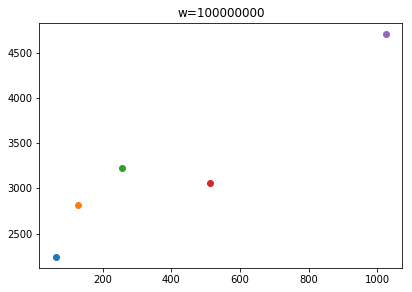

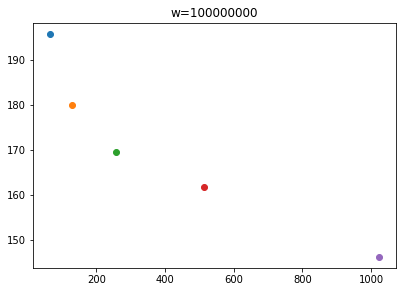

In [31]:
fig = plt.figure()
fig.set_size_inches(6.5, 4.5, forward=True)

for k in best_l_i.keys():
    if k[0] == 100000000 and k[1] in [32]:
        for i in best_l_i[k].keys():
            plt.title("w="+str(k[0]))
            plt.plot(i, best_l_i[k][i], "o-", label="$w$="+str(i))
            #plt.legend()
            
fig = plt.figure()
fig.set_size_inches(6.5, 4.5, forward=True)

for k in best_l_e.keys():
    if k[0] == 100000000 and k[1] in [32]:
        for i in best_l_e[k].keys():
            plt.title("w="+str(k[0]))
            plt.plot(i, best_l_e[k][i], "o-", label="$w$="+str(i))
            #plt.legend()
            

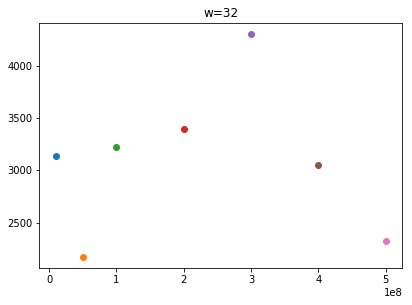

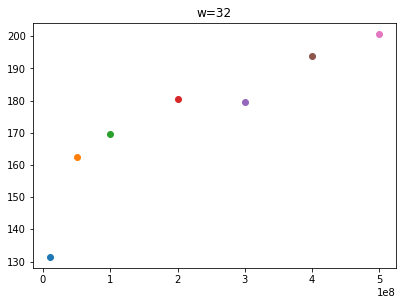

In [29]:
fig = plt.figure()
fig.set_size_inches(6.5, 4.5, forward=True)

for k in best_w_i.keys():
    if k[0] == 32 and k[1] in [256]:
        for i in best_w_i[k].keys():
            plt.title("w="+str(k[0]))
            plt.plot(i, best_w_i[k][i], "o-", label="$w$="+str(i))
            #plt.legend()
            
fig = plt.figure()
fig.set_size_inches(6.5, 4.5, forward=True)

for k in best_w_e.keys():
    if k[0] == 32 and k[1] in [256]:
        for i in best_w_e[k].keys():
            plt.title("w="+str(k[0]))
            plt.plot(i, best_w_e[k][i], "o-", label="$w$="+str(i))
            #plt.legend()

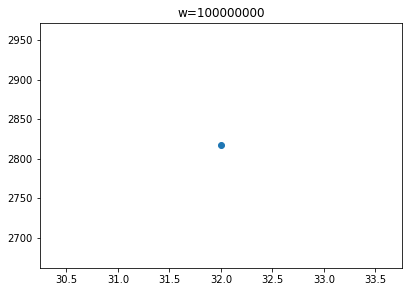

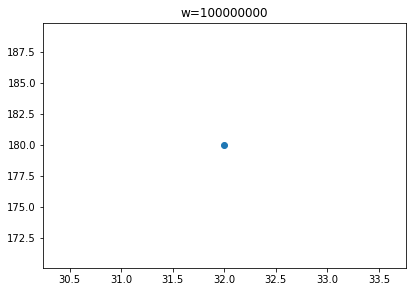

In [30]:
fig = plt.figure()
fig.set_size_inches(6.5, 4.5, forward=True)

for k in best_p_i.keys():
    if k[0] == 100000000 and k[1] in [128]:
        for i in best_p_i[k].keys():
            plt.title("w="+str(k[0]))
            plt.plot(i, best_p_i[k][i], "o-", label="$w$="+str(i))
            #plt.legend()
            
fig = plt.figure()
fig.set_size_inches(6.5, 4.5, forward=True)

for k in best_p_e.keys():
    if k[0] == 100000000 and k[1] in [128]:
        for i in best_p_e[k].keys():
            plt.title("w="+str(k[0]))
            plt.plot(i, best_p_e[k][i], "o-", label="$w$="+str(i))
            #plt.legend()